# Arxiv Title Generation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm import tqdm

import collections
import copy
import random
import math
import time
import gc

def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
    
init_random_seed(1234)

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
MODEL_NAME = "Callidior/bert2bert-base-arxiv-titlegen"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

D:\Dev\jupyter\projects\Data Science\ds_stuff\Different courses\Нейронные сети и обработка текста\venv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Роман\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Data

In [5]:
tokenizer

BertTokenizerFast(name_or_path='Callidior/bert2bert-base-arxiv-titlegen', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [6]:
data = pd.read_csv('data/train.csv')
print(data.shape)
data.head()

(135000, 2)


,abstract,title
0,we consider the problem of utility maximizatio...,on optimal investment with processes of long o...
1,in this paper we provide an explicit formula f...,boolean complexes for ferrers graphs
2,"kinesin-5, also known as eg5 in vertebrates is...",relative velocity of sliding of microtubules b...
3,we discuss the transition paths in a coupled b...,bifurcation of transition paths induced by cou...
4,two types of room temperature detectors of ter...,all-electric detectors of the polarization sta...


In [7]:
data = data[~(data['abstract'].apply(len) <= data['title'].apply(len))].reset_index(drop=True)

In [8]:
data = data.drop_duplicates().reset_index(drop=True)

In [9]:
data = data[~(data['abstract'].apply(lambda x: 'withdrawn' in x.lower()))]

In [10]:
data.sample(1)['abstract'].values[0], data.sample(1)['title'].values[0]

('we study s-wave superconductivity in the two-dimensional square lattice attractive hubbard hamiltonian for various inhomogeneous patterns of interacting sites. using the bogoliubov-de gennes (bdg) mean field approximation, we obtain the phase diagram for inhomogeneous patterns in which the on-site attractive interaction u_i between the electrons takes on two values, u_i=0 and -u/(1-f) (with f the concentration of non-interacting sites) as a function of average electron occupation per site n, and study the evolution of the phase diagram as f varies. in certain regions of the phase diagram, inhomogeneity results in a larger zero temperature average pairing amplitude (order parameter) and also a higher superconducting (sc) critical temperature t_c, relative to a uniform system with the same mean interaction strength (u_i=-u on all sites). these effects are observed for stripes, checkerboard, and even random patterns of the attractive centers, suggesting that the pattern of inhomogeneity

In [11]:
data = data.drop_duplicates('abstract').reset_index(drop=True)

In [12]:
data = data.drop_duplicates('title').reset_index(drop=True)
data.shape

(105209, 2)

# Train-Test split

In [13]:
init_random_seed(1234)

val_ratio = 0.01
test_ratio = 0.01

val_idx = np.random.choice(a=len(data), size=int(len(data)*(val_ratio+test_ratio)), replace=False)

train_data = data.drop(val_idx).copy()
val_data = data.iloc[val_idx[:len(val_idx)//2]].copy()
test_data = data.iloc[val_idx[len(val_idx)//2:]].copy()

In [14]:
val_idx

array([31660, 86648, 50463, ...,  4110, 20593, 80406])

In [15]:
# check if there's no intersection among sets
print(set(train_data.index).intersection(set(val_data.index)))
print(set(train_data.index).intersection(set(test_data.index)))
print(set(val_data.index).intersection(set(test_data.index)))

set()
set()
set()


In [16]:
train_data.values[0][0], train_data.values[0][1]

('we consider the problem of utility maximization for investors with power utility functions. building on the earlier work larsen et al. (2016), we prove that the value of the problem is a frechet-differentiable function of the drift of the price process, provided that this drift lies in a suitable banach space.   we then study optimal investment problems with non-markovian driving processes. in such models there is no hope to get a formula for the achievable maximal utility. applying results of the first part of the paper we provide first order expansions for certain problems involving fractional brownian motion either in the drift or in the volatility. we also point out how asymptotic results can be derived for models with strong mean reversion.',
 'on optimal investment with processes of long or negative memory')

In [17]:
test_data.values[0]

array(['anderson has recently proposed a theory of the strange metal state above tc in the high tc superconductors. [arxiv:cond-mat/0512471] it is based on the idea that the unusual transport properties and spectral functions are caused by the strong mott- hubbard interactions and can be computed by using the formal apparatus of gutzwiller projection. in ref. 1 anderson computed only the tunneling spectrum and the power-law exponent of the infrared conductivity. he had calculated the energy distribution curves (edcs) in angle resolved photoemission spectroscopy (arpes) but was discouraged when these differed radically from the best arpes measurements available at the time, and did not include them. in this letter we compare the spectral functions computed within this model to the novel laser-arpes data of the dessau group.these are found to capture the shape of the experimental edcs with unprecedented accuracy and in principle have only one free parameter.',
       'accurate theoretica

In [18]:
encoded_sample = tokenizer(test_data['title'].values[0])
print(encoded_sample)

{'input_ids': [101, 8321, 9373, 16142, 2000, 9138, 12098, 10374, 3968, 6169, 1999, 1996, 3671, 4403, 1997, 2452, 11657, 3565, 8663, 8566, 24817, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [19]:
print(tokenizer.decode(encoded_sample.input_ids))
del encoded_sample
gc.collect()

[CLS] accurate theoretical fits to laser arpes edcs in the normal phase of cuprate superconductors [SEP]


8

## Sorting texts by their length

In [20]:
%%time
train_data['len_abstract'] = train_data['abstract'].apply(lambda x: len(tokenizer.encode(x)))
train_data['len_title'] = train_data['title'].apply(lambda x: len(tokenizer.encode(x)))
train_data = train_data.sort_values(['len_abstract', 'len_title'], ascending=False)

val_data['len_abstract'] = val_data['abstract'].apply(lambda x: len(tokenizer.encode(x)))
val_data['len_title'] = val_data['title'].apply(lambda x: len(tokenizer.encode(x)))
val_data = val_data.sort_values(['len_abstract', 'len_title'], ascending=False)

test_data['len_abstract'] = test_data['abstract'].apply(lambda x: len(tokenizer.encode(x)))
test_data['len_title'] = test_data['title'].apply(lambda x: len(tokenizer.encode(x)))
test_data = test_data.sort_values(['len_abstract', 'len_title'], ascending=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (556 > 512). Running this sequence through the model will result in indexing errors


CPU times: total: 57.8 s
Wall time: 57.8 s


In [21]:
train_data['len_abstract'].max(), train_data['len_title'].max()

(1096, 103)

In [22]:
train_data['len_title'].mean(), train_data['len_title'].median()

(16.072692885893023, 15.0)

In [23]:
train_data['len_abstract'].mean(), train_data['len_abstract'].median()

(190.76232966393482, 180.0)

In [24]:
class ArxivDataset(torch.utils.data.Dataset):
    def __init__(self,
                 src,
                 trg,
                 tokenizer,
                 src_max_len,
                 trg_max_len
                ):
        self.src = src
        self.trg = trg
        self.tokenizer = tokenizer
        self.src_max_len = src_max_len
        self.trg_max_len = trg_max_len
        
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, i):
        # добавляем токены начала и конца предложения
        src_i = self.src[i]
        trg_i = self.trg[i]
        
        src_encoding = self.tokenizer(
            src_i,
            max_length=self.src_max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )
        
        trg_encoding = self.tokenizer(
            trg_i,
            max_length=self.trg_max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )
        
        labels = trg_encoding["input_ids"]
        labels[labels == 0] = -100
        
        return dict(abstract=src_i,
                    title=trg_i,
                    abstract_input_ids=src_encoding["input_ids"].flatten(),
                    abstract_attention_mask=src_encoding["attention_mask"].flatten(),
                    labels=labels.flatten(),
                    labels_attention_mask=trg_encoding["attention_mask"].flatten())

In [25]:
%%time
arx_dataset_train = ArxivDataset(
    train_data['abstract'].values.tolist(),
    train_data['title'].values.tolist(),
    tokenizer,
    src_max_len=512,
    trg_max_len=35
)
arx_dataset_val = ArxivDataset(
    val_data['abstract'].values.tolist(),
    val_data['title'].values.tolist(),
    tokenizer,
    src_max_len=512,
    trg_max_len=35
)
arx_dataset_test = ArxivDataset(
    test_data['abstract'].values.tolist(),
    test_data['title'].values.tolist(),
    tokenizer,
    src_max_len=512,
    trg_max_len=35
)

CPU times: total: 0 ns
Wall time: 4.01 ms


In [26]:
print(arx_dataset_train[1])

{'abstract': 'superoxide reductase (sor) is an fe protein that catalyzes the reduction of superoxide to give h(2)o(2). recently, the mutation of the glu47 residue into alanine (e47a) in the active site of sor from desulfoarculus baarsii has allowed the stabilization of an iron-peroxo species when quickly reacted with h(2)o(2) [math{\\\'e} et al. (2002) j. am. chem. soc. 124, 4966-4967]. to further investigate this non-heme peroxo-iron species, we have carried out a m{\\"o}ssbauer study of the (57)fe-enriched e47a sor from d. baarsii reacted quickly with h(2)o(2). considering the m{\\"o}ssbauer data, we conclude, in conjunction with the other spectroscopic data available and with the results of density functional calculations on related models, that this species corresponds to a high-spin side-on peroxo-fe(3+) complex. this is one of the first examples of such a species in a biological system for which m{\\"o}ssbauer parameters are now available: delta(/fe) = 0.54 (1) mm/s, deltae(q) = 

In [27]:
BATCH_SIZE = 32
train_data_loader = torch.utils.data.DataLoader(
    arx_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [28]:
j = 0
for data in train_data_loader:
    print(data['abstract_input_ids'].to(device).shape)
    j += 1
    if j == 3:
        break
        
# del train_data_loader#, val_data_loader, test_data_loader
# gc.collect()
# torch.cuda.empty_cache()

torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])


# Modeling

In [29]:
class ArxivModel(torch.nn.Module):
    def __init__(self, model_name):
        super(ArxivModel, self).__init__()
        
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name, return_dict=True)

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):

        x = self.model(input_ids,
                       attention_mask=attention_mask,
                       decoder_attention_mask=decoder_attention_mask,
                       labels=labels
                       )
        
        return x.logits, x.loss

In [30]:
model = ArxivModel(MODEL_NAME).to(device)

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 247,363,386 trainable parameters


In [32]:
optimizer = optim.AdamW(model.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
lr_sched = None

In [33]:
def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=3,
                                                      factor=0.5,
                                                      verbose=True)

lr_sched = lr_scheduler(optimizer)

In [34]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    
    model.train()
    
    epoch_loss = 0
    history = []
    
    for i, batch in enumerate(iterator):
        
        input_ids = batch["abstract_input_ids"].to(device)
        attention_mask = batch["abstract_attention_mask"].to(device)
        labels = batch["labels"].to(device)
        labels_attention_mask = batch["labels_attention_mask"].to(device)
        
        optimizer.zero_grad()
        
        output, loss = model(input_ids, attention_mask, labels_attention_mask, labels)

        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator)

In [35]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            input_ids = batch["abstract_input_ids"].to(device)
            attention_mask = batch["abstract_attention_mask"].to(device)
            labels = batch["labels"].to(device)
            labels_attention_mask = batch["labels_attention_mask"].to(device)

            output, loss = model(
                input_ids,
                attention_mask,
                labels_attention_mask,
                labels
            )

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [37]:
MODEL_NAME = 'models/bert2bert.pt'

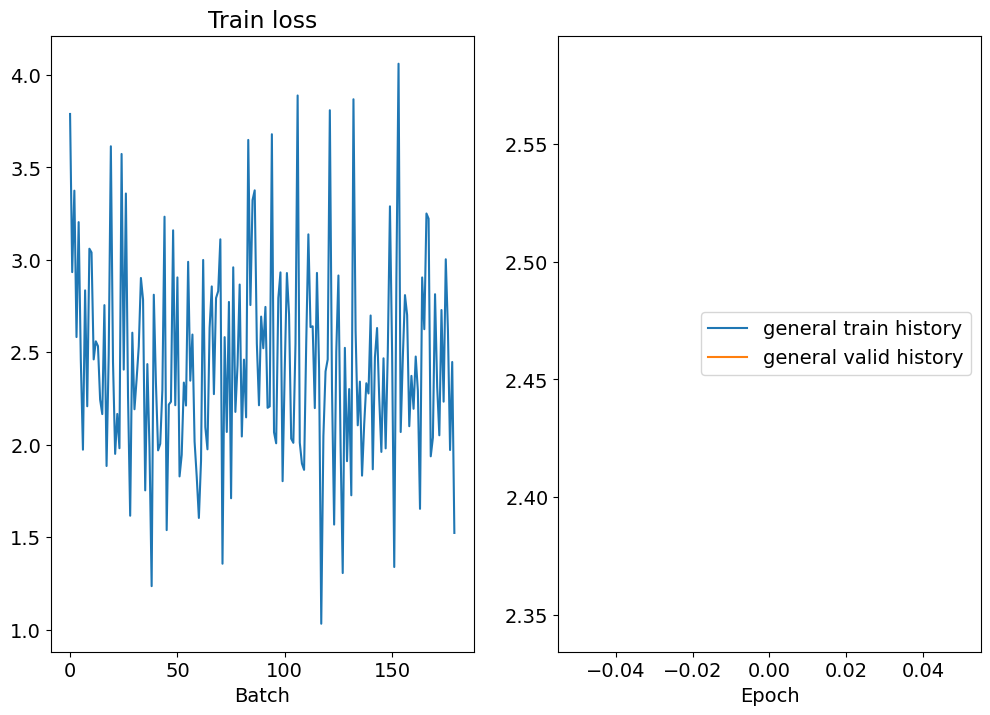

KeyboardInterrupt: 

In [52]:
N_EPOCHS = 15
CLIP = 1
BATCH_SIZE = 4

train_data_loader = torch.utils.data.DataLoader(
    arx_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=False
)

val_data_loader = torch.utils.data.DataLoader(
    arx_dataset_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_history = []
valid_history = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_data_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, val_data_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)
        
    if lr_sched is not None:
        lr_sched.step(valid_loss)
        
        
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [53]:
# del test_data_loader
# gc.collect()
# torch.cuda.empty_cache()

In [54]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [55]:
# for cpu usage
model.load_state_dict(torch.load(MODEL_NAME, map_location=device))

test_data_loader = torch.utils.data.DataLoader(
    arx_dataset_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_loss = evaluate(model, test_data_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.622 | Test PPL:  13.770 |


# Generating

In [74]:
def translate_sentence(text, tokenizer, model):
    
    model.eval()
    
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    generated_ids = model.model.generate(
        input_ids=text_encoding["input_ids"].to(device),
        attention_mask=text_encoding["attention_mask"].to(device),
        max_length=45,
        num_beams=5,
        repetition_penalty=2.5,
        length_penalty=1,
        early_stopping=True
    )

    preds = [tokenizer.decode(gen_id, 
                              skip_special_tokens=True, 
                              clean_up_tokenization_spaces=True) for gen_id in generated_ids]

    return " ".join(preds)

In [75]:
example_idx = 100

ex = arx_dataset_train[example_idx]

print(f'src = {ex["abstract"]}\n')
print(f'trg = {ex["title"]}')

src = i report the analysis performed on fermion masses and mixing, including neutrino mixing, within the context of a model with hierarchical radiative mass generation mechanism for light charged fermions, mediated by exotic scalar particles at one and two loops, respectively, meanwhile the neutrinos get majorana mass terms at tree level through the yukawa couplings with two su(2)_l higgs triplets. all the resulting mass matrices in the model, for the u, d, and e fermion charged sectors, the neutrinos and the exotic scalar particles, are diagonalized in exact analytical form. quantitative analysis shows that this model is successful to accommodate the hierarchical spectrum of masses and mixing in the quark sector as well as the charged lepton masses. the lepton mixing matrix, v_{pmns}, is written completely in terms of the neutrino masses m_1, m_2, and m_3. large lepton mixing for \theta_{12} and \theta_{23} is predicted in the range of values 0.7 \lesssim \sin^22\theta_{12}\lesssim 0

In [76]:
pred = translate_sentence(ex['abstract'], tokenizer, model)
print(f'pred = {pred}')

pred = lepton masses and neutrino mixing


# Submission

In [77]:
submission_data = pd.read_csv('data/test.csv')
abstracts = submission_data['abstract'].values

In [78]:
from joblib import Parallel, delayed

_parallel = Parallel(n_jobs=6, max_nbytes=None, timeout=99999)

def translate(text):
    return translate_sentence(text, tokenizer=tokenizer, model=model)

def parallel_function(function, data):
    return _parallel(delayed(function)(sample) for sample in tqdm(data))

result = parallel_function(translate, abstracts)

# titles = []
# for abstract in tqdm(abstracts):
#     title = translate_sentence(
#         model=model,
#         text=abstract,
#         tokenizer=tokenizer)
#     titles.append(title)

  2%|█▌                                                                              | 19/1000 [00:27<31:17,  1.91s/it]D:\Dev\jupyter\projects\Data Science\ds_stuff\Different courses\Нейронные сети и обработка текста\venv\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [52:02<00:00,  3.12s/it]


In [79]:
result[0]

'a model - free decoding approach to neural machine translation'

In [80]:
submission_df = pd.DataFrame({'abstract': abstracts, 'title': result})
submission_df.to_csv('predicted_titles.csv', index=False)

In [84]:
import string
from nltk.util import ngrams
import numpy as np
import pandas as pd
import pickle


def generate_csv(input_file='predicted_titles.csv',
                 output_file='submission.csv',
                 voc_file='data/vocs.pkl'):
    '''
    Generates file in format required for submitting result to Kaggle
    
    Parameters:
        input_file (str) : path to csv file with your predicted titles.
                           Should have two fields: abstract and title
        output_file (str) : path to output submission file
        voc_file (str) : path to voc.pkl file
    '''
    data = pd.read_csv(input_file)
    with open(voc_file, 'rb') as voc_file:
        vocs = pickle.load(voc_file)

    with open(output_file, 'w') as res_file:
        res_file.write('Id,Predict\n')
        
    output_idx = 0
    for row_idx, row in data.iterrows():
        trg = row['title']
        trg = trg.translate(str.maketrans('', '', string.punctuation)).lower().split()
        trg.extend(['_'.join(ngram) for ngram in list(ngrams(trg, 2)) + list(ngrams(trg, 3))])
        
        VOCAB_stoi = vocs[row_idx]
        trg_intersection = set(VOCAB_stoi.keys()).intersection(set(trg))
        trg_vec = np.zeros(len(VOCAB_stoi))    

        for word in trg_intersection:
            trg_vec[VOCAB_stoi[word]] = 1

        with open(output_file, 'a') as res_file:
            for is_word in trg_vec:
                res_file.write('{0},{1}\n'.format(output_idx, int(is_word)))
                output_idx += 1


generate_csv()

In [85]:
pd.read_csv('submission.csv')

,Id,Predict
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
343437,343437,0
343438,343438,0
343439,343439,0
343440,343440,0


In [86]:
pd.read_csv('predicted_titles.csv')['title']

0      a model - free decoding approach to neural mac...
1      a comparison of techniques for the generation ...
2             a new class of non - markovian multilayers
3      using coverage - based neural machine to impro...
4        a few examples : unsupervised image translation
                             ...                        
995               on the construction of subsystem codes
996    the generalized energy identity for spin surfaces
997             on the kloosterman sums of a prime power
998    the rate of growth for a class of systems with...
999               entanglement in the spin - 1 / 2 model
Name: title, Length: 1000, dtype: object